In [1]:
# Import Libraries
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Import

In [2]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [4]:
df = wrangle("/home/linuxdavid/Machine_Learning_Specialization/WQU/EarthQuake/nepal.sqlite")

df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


# Split

In order to split our data, we'll be using the train_test_split function from scikit-learn. We'll begin by splitting our data into a training and testing set. Next, we'll apply the train_test_split function to our testing set to generate our validation dataset and new testing dataset.


Validation datasets are usually used to tune model hyperparameters. A hyperparameter is a model setting that can't be learned during model training and must be explicitly set. In contrast, a model parameter can be learned. An example of a hyperparameter is the depth of a decision tree

In [5]:
# Create feature matrix X and target vector y. 
# Recall the target is "severe_damage"
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

I'll divide the data (X and y) into training and test sets using a randomized train-test split. The test set will be 20% of the total data.

In [6]:
# Randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Now i'll divide the training data (X_train and y_train) into training and validation sets using a randomized train-test split. The validation data will be 20% of the remaining data.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Build Model

## Baseline

Now I'll calculate the baseline accuracy for the model

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


# Iterate

Decision trees are a general class of machine learning models that are used for both classification and regression. The model resemble a tree, complete with branches and leaves. The model is essentially a series of questions with "yes" or "no" answers. The decision tree starts by checking whatever condition does the best job at correctly separating the data into the two classes in the binary target. It then progressively checks more conditions until it can predict an observation's label

For many machine learning algorithms, it's common to use one-hot encoding. This works well if there are a few categories, but as the number of features grows, the number of additional columns also grows.

Having a large number of columns (and consequently a large number of features in your model) can lead to a number of issues often referred to as the curse of dimensionality. Two primary issues that can arise are computational complexity (operations performed on larger datasets may take longer) and overfitting (the model may not generalize to new data). In these scenarios, ordinal encoding is a popular choice for encoding the categorical variable. Instead of creating new columns, ordinal encoding simply replaces the categories in a categorical variable with integers.

In [18]:
# Build Model
model = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(max_depth=6, random_state=42)
    
)

# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Stone                    2
RC, engineered           3
Brick, cement mortar     4
Adobe/mud                5
Timber                   6
RC, non-engineered       7
Brick, mud mortar        8
Stone, cement mortar     9
Bamboo                  10
Other                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

Next, i'll calculate the training and validation accuracy scores.

In [19]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = accuracy_score(y_val, model.predict(X_val))

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.72
Validation Accuracy: 0.72


The training accuracy is 0.98 and the validation accuracy is 0.65, that's a massive problem.
The model is overfitting to the training data.

To tackle this, i'll check the current depth of the tree during the training

In [20]:
tree_depth = model.named_steps['decisiontreeclassifier'].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 6


49 is a lot, and that is too much flexibility hence the overfitting.

I'll need to carry out hyperparameter tuning to find the best depth to train the data with.
To do that, I will create a range of possible values for max_depth hyperparameter of my model's DecisionTreeClassifier. depth_hyperparams will range from 1 to 50 by steps of 2

In [15]:
depth_hyperparams = range(1, 50, 2)

Next, i'll create a for loop that trains a model for every max_depth in depth_hyperparams. Every time a new model is trained, the code will also calculate the training and validation accuracy scores and append them to the training_acc and validation_acc lists, respectively.

In [16]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model =  make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth=d, random_state=42)
)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7071072484228174, 0.7117395332421582, 0.7162394670666608]
Validation Accuracy Scores: [0.7088406564319746, 0.7132521616375508, 0.7166049055937886]


That looks good, as the scores are higher than the baseline, but a plot would paint a better picture.Next I will create a visualization with two lines. The first line should plot the training_acc values as a function of depth_hyperparams, and the second should plot validation_acc as a function of depth_hyperparams

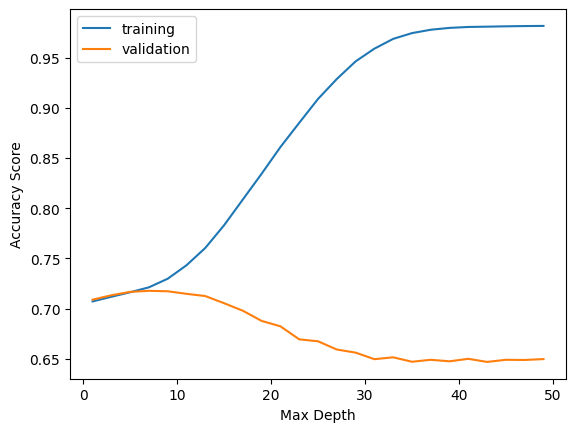

In [17]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

Based on the viz above, the max_depth value that leads to the best validation accuracy score is 6.
Now i will retrain the orginal model and add the max_depth argument to it and see how well it solves the overfitting problem.

# Evaluate

In [21]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.72


# Communicate

Here, i will visualize the decision logic of my model

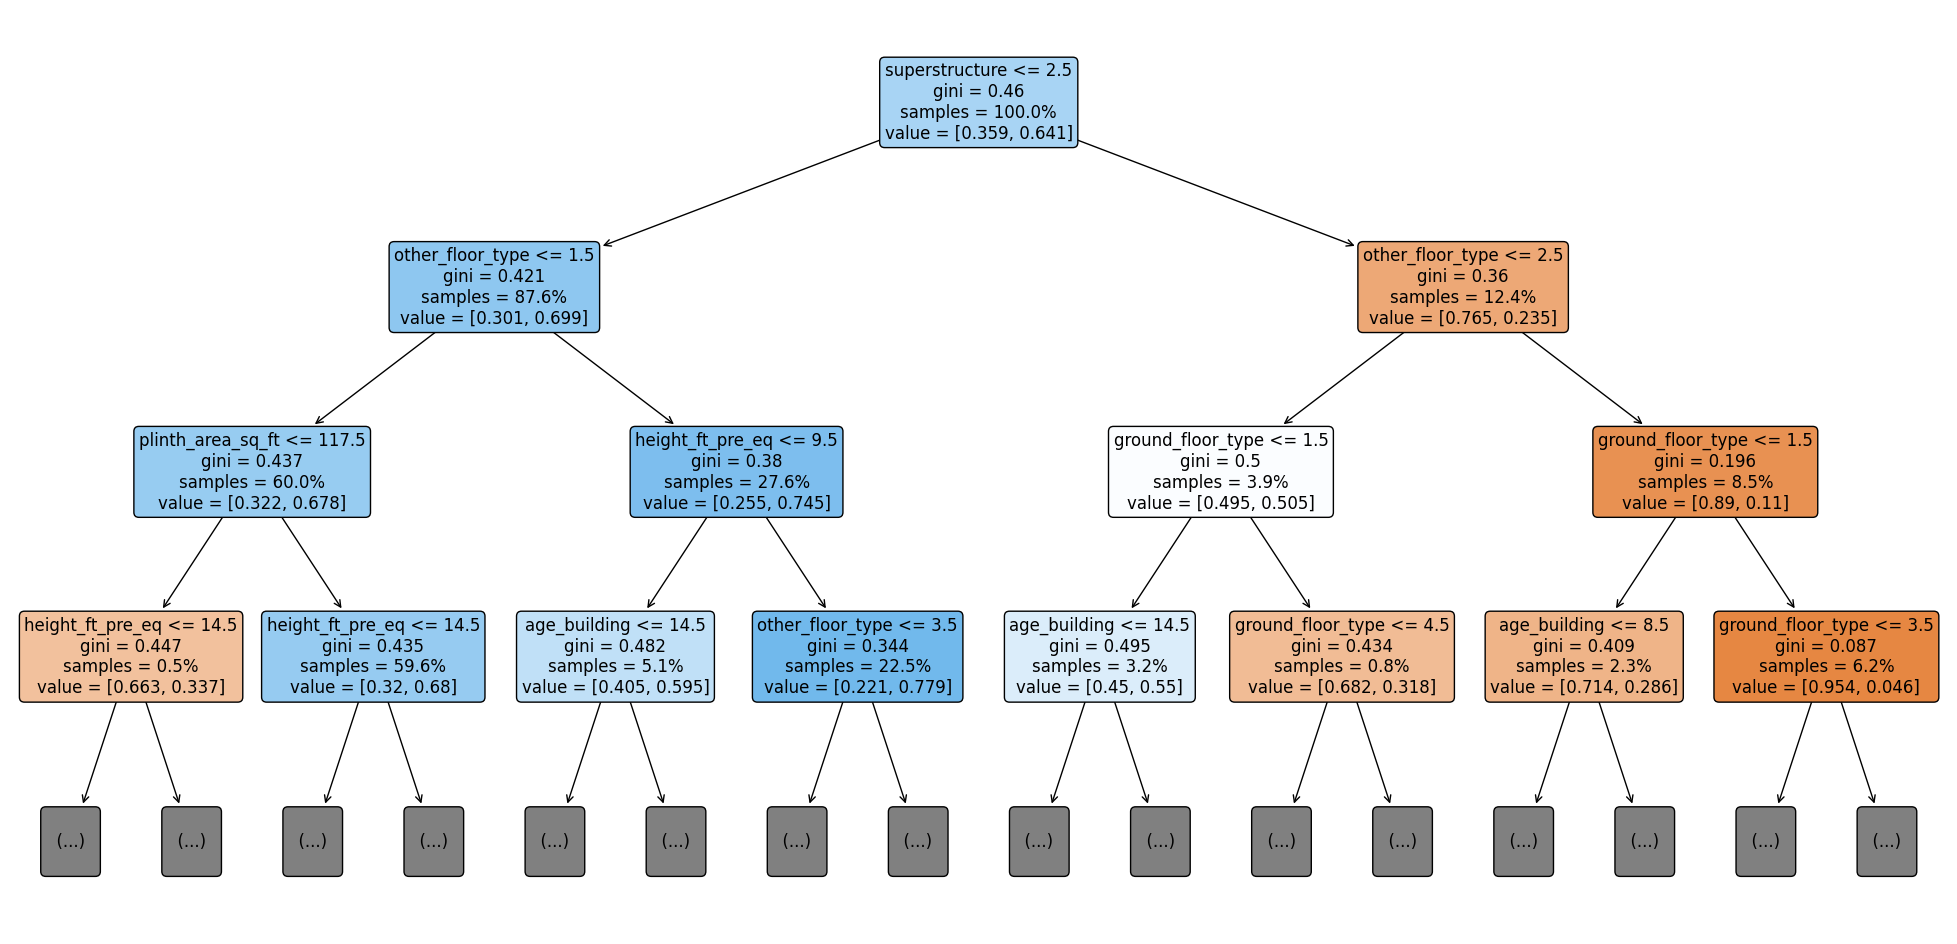

In [22]:
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In decision tree plot above, each node represents a binary decision based on a specific feature and a threshold value. In addition to the feature and threshold used to make the decision, there are four pieces of information displayed in each node of the decision tree:

* Split criteria: This is the feature and threshold value used to make the binary decision at that node.
* Gini importance: This is a measure of the impurity of the node. A higher value indicates that the node is more impure, meaning that the samples in the node are more evenly split across multiple classes.
* Total number of samples: This is the total number of samples that reached that node during the training process.
* Proportion of the samples: This is the proportion of samples in the node that belong to each    class.
As you move further down the tree, you'll notice that the nodes become increasingly blue or orange in color. This color-coding represents the severity of damage, where blue indicates severe damage, and orange indicates less severe damage.

However, it's important to note that the color-coding may not always be related to damage, and its interpretation may vary depending on the specific problem and how the decision tree is constructed.

Finally, the visualization shown only displays the first three depths of the tree.

Next i'll get the feature names and importances and then create a pandas Seies with them where the index is features and the values are the importances.


In [23]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_


print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.03515085 0.04618639 0.08839161]


In [24]:
feat_imp = pd.Series(importances, index=features).sort_values()

feat_imp.head()

position                  0.000644
plan_configuration        0.004847
foundation_type           0.005206
roof_type                 0.007620
land_surface_condition    0.020759
dtype: float64

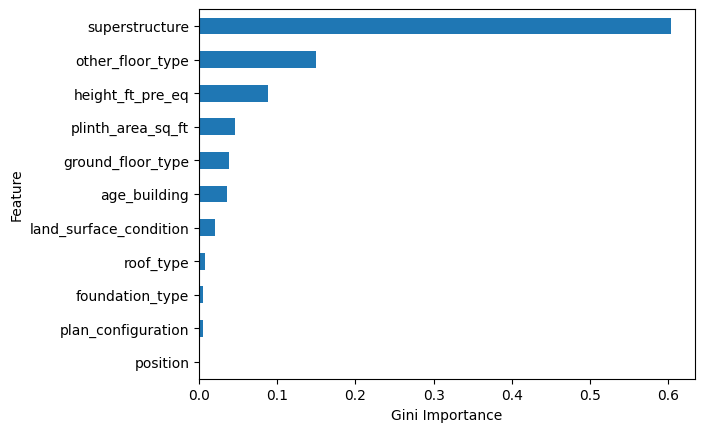

In [25]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

Notice how all the gini importance of the features range from 0 to 1 and they also sum to 1.
The Superstructure feature for example is at 0.6 and that means that over the course of the splits which the tree does, going from the root to the leaves, the superstructure is responsible for about 60% of the decrease in impurity in the nodes. This visualization shows the importance of each feature in decreasing impurity in the nodes.